In [1]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from preprocessing import get_clean_data
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
from sklearn.ensemble import IsolationForest
from score import get_labels
from score import calc_precision, calc_recall, calc_f1_score
import gc
from tqdm import tqdm_notebook
from functools import reduce

## Loading data

In [2]:
%%time
generate_station_id = [615, 618, 620, 624, 626, 627, 635, 702, 
                       704, 862, 874, 888, 1808, 1813, 1826]

raw = load_mm94_stations(generate_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis)
data = create_patterns(mmx_rwis_interpolated)
data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_t_road', ))
data_clean = get_clean_data(data)
data_clean = data_clean.reset_index(drop=True)

gc.collect()

KeyboardInterrupt: 

## Plot

In [3]:
import matplotlib.pyplot as plt

z = copy(data_clean[data_clean['station_id']==615].set_index('date_time_utc'))
#z = copy(data_clean.set_index('date_time_utc'))
start = pd.Timestamp(2012, 1, 1)
end = pd.Timestamp(2017, 12, 1)

to_plot = z[(z.index<=end) & (z.index>=start)]

plt.figure(figsize=(30, 10))

plt.plot_date(to_plot.index, to_plot['data_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='t_road')

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температура дороги, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()

KeyboardInterrupt: 

## Generated anomalies

### Single outlier

In [ ]:
def generate_single_anomaly(df, index, col=MmxColumns.ROAD_TEMPERATURE):
    sign = np.random.choice([1, -1])
    series_adding = sign * np.random.uniform(2, 5)
    
    perturbated_series = df.loc[index, col] + series_adding
    return perturbated_series

np.random.seed(42)
test = copy(data_clean)
test['label_true'] = False

number_of_anomalies = 30 * len(generate_station_id)
col = MmxColumns.ROAD_TEMPERATURE
index_list = np.random.choice(test.index, number_of_anomalies, replace=False)

for index in index_list:
    perturbated_series = generate_single_anomaly(test, index)
    test.loc[index, col] += perturbated_series
    test.loc[index, 'label_true'] = True

In [ ]:
# generate_station_id = [615, 618, 620, 624, 626, 627, 635, 702, 
#                       704, 862, 874, 888, 1808, 1813, 1826]
start = pd.Timestamp(2015, 12, 20)
end = pd.Timestamp(2016, 1, 27)

to_plot = test[test['station_id']==615]
to_plot = to_plot[(to_plot['date_time_utc']<=end) & (to_plot['date_time_utc']>=start)]
to_plot = to_plot.set_index('date_time_utc')


plt.figure(figsize=(30, 10))

for elem in [False, True]:
    cond = to_plot['label_true'] == elem
    if elem:
        plt.plot_date(to_plot[cond].index, to_plot[cond]['data_t_road'], 'r',
                      linestyle='none', marker='o', markersize=10, label='artificial outliers')
    else:
        plt.plot_date(to_plot[cond].index, to_plot[cond]['data_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='initial data')

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Road surface temperature, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()
#plt.savefig('/mnt/HARD/MinMax94/plots/single_outliers.png')

### Short-term anomaly

In [ ]:
def generate_short_term_anomaly(df, index, col=MmxColumns.ROAD_TEMPERATURE):
    series_duration = np.random.randint(3, 12)
    sign = np.random.choice([1, -1])
    
    series_adding = sign * np.random.exponential(2, series_duration)
    perturbation = np.cumsum(series_adding)
    
    perturbated_series = df.loc[index: (index+series_duration-1), col] + perturbation
    return perturbated_series


number_of_anomalies = 20 * len(generate_station_id)
col = MmxColumns.ROAD_TEMPERATURE
index_list = np.random.choice(test.index, number_of_anomalies, replace=False)

for index in index_list:
    perturbated_series = generate_short_term_anomaly(test, index)
    series_duration = len(perturbated_series)
    test.loc[index: (index + series_duration - 1), col] += perturbated_series
    test.loc[index: (index + series_duration - 1), 'label_true'] = True

In [ ]:
# generate_station_id = [615, 618, 620, 624, 626, 627, 635, 702, 
#                       704, 862, 874, 888, 1808, 1813, 1826]

start = pd.Timestamp(2013, 12, 29)
end = pd.Timestamp(2014, 1, 20)

to_plot = test[test['station_id']==618]
to_plot = to_plot[(to_plot['date_time_utc']<=end) & (to_plot['date_time_utc']>=start)]
to_plot = to_plot.set_index('date_time_utc')


plt.figure(figsize=(30, 10))

for elem in [False, True]:
    cond = to_plot['label_true'] == elem
    if elem:
        plt.plot_date(to_plot[cond].index, to_plot[cond]['data_t_road'], 'r',
                      linestyle='none', marker='o', markersize=9, label='artificial outliers')
    else:
        plt.plot_date(to_plot[cond].index, to_plot[cond]['data_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='initial data')

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Road surface temperature, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()
#plt.savefig('/mnt/HARD/MinMax94/plots/short_term_outliers.png')

### Long term anomaly

In [8]:
def generate_long_term_anomaly(df, index, col=MmxColumns.ROAD_TEMPERATURE):
    series_duration = np.random.randint(300)
    multiplier = np.random.uniform(1.5, 2)
    perturbation = np.random.normal(0, 5, series_duration)
    #print(series_duration, multiplier, index)
    
    perturbated_series = df.loc[index: (index + series_duration - 1), 'data_t_road'] * multiplier + perturbation
    return perturbated_series

number_of_anomalies = 3 * len(generate_station_id)
col = MmxColumns.ROAD_TEMPERATURE
index_list = np.random.choice(test.index, number_of_anomalies, replace=False)

for index in index_list:
    perturbated_series = generate_long_term_anomaly(test, index)
    series_duration = len(perturbated_series)
    test.loc[index: (index + series_duration - 1), col] += perturbated_series
    test.loc[index: (index + series_duration - 1), 'label_true'] = True

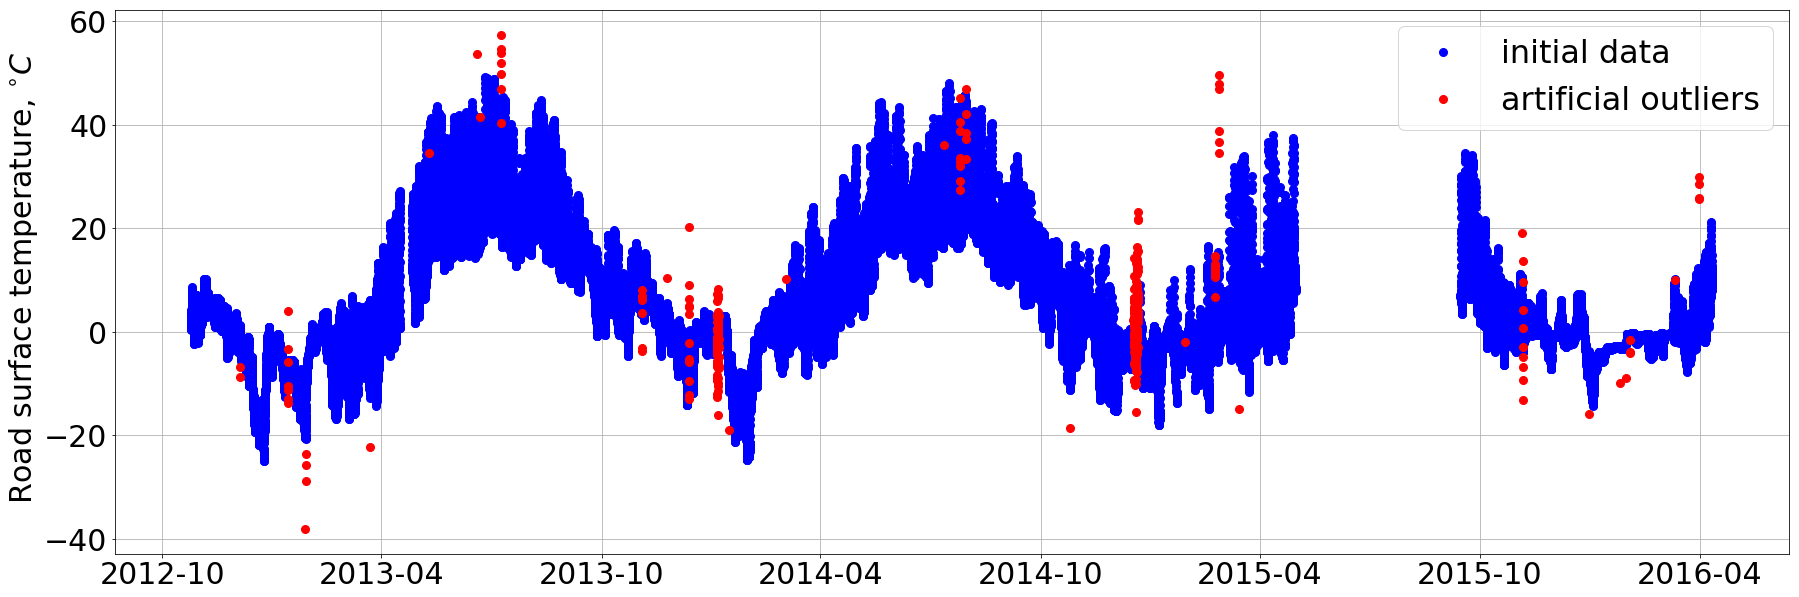

In [9]:
# generate_station_id = [615, 618, 620, 624, 626, 627, 635, 702, 
#                       704, 862, 874, 888, 1808, 1813, 1826]

start = pd.Timestamp(2012, 1, 1)
end = pd.Timestamp(2017, 1, 1)

to_plot = test[test['station_id']==615]
to_plot = to_plot[(to_plot['date_time_utc']<=end) & (to_plot['date_time_utc']>=start)]
to_plot = to_plot.set_index('date_time_utc')

plt.figure(figsize=(30, 10))

for elem in [False, True]:
    cond = to_plot['label_true'] == elem
    if elem:
        plt.plot_date(to_plot[cond].index, to_plot[cond]['data_t_road'], 'r',
                      linestyle='none', marker='o', markersize=8, label='artificial outliers')
    else:
        plt.plot_date(to_plot[cond].index, to_plot[cond]['data_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='initial data')

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Road surface temperature, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()
#plt.savefig('/mnt/HARD/MinMax94/plots/long_term_outliers.png')
#plt.savefig('/mnt/HARD/MinMax94/plots/all_outliers.png')

## XGBoost_7

In [10]:
%%time
import xgboost as xgb
from preprocessing import create_feature_df
from sklearn.metrics import mean_absolute_error

point = pd.Timestamp(2015, 6, 1)

time = 0.5
variables = ['data_t_road']
df_xgb_7 = create_feature_df(test, winter_period=False, time=time,
                           variables=variables)

features = [col for col in df_xgb_7 if col.startswith('data_')]
target = [col for col in df_xgb_7 if col.startswith('target_')][0]

X_test = np.array(df_xgb_7[features].values)
y_test = np.array(df_xgb_7[target].values.reshape(-1, 1))
dtest = xgb.DMatrix(X_test, y_test)

CPU times: user 1.53 s, sys: 509 ms, total: 2.04 s
Wall time: 2.04 s


In [11]:
import pickle
import numpy as np

clf = pickle.load(open('/mnt/HARD/MinMax94/models/pickle/xgboost.pickle', 'rb'))
y_true = dtest.get_label()
y_pred = clf.predict(dtest).ravel()

std = 0.889
upper = y_pred + std * 7
lower = y_pred - std * 7
df_xgb_7['label_predict'] = ((y_true >= upper) | (y_true <= lower))
df_xgb_7['decision_function'] = np.abs(y_true - y_pred)

In [12]:
st_id = generate_station_id
window = pd.Timedelta('4h')

#st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]

recall = calc_recall(df_xgb_7, st_id, window)
precision = calc_precision(df_xgb_7, st_id, window)
f1_score = calc_f1_score(precision, recall)


print("Recall = {0:.3f} \nPrecision = {1:.3f} \nF1 = {2:.3f}".format(recall, precision, f1_score))
print(df_xgb_7[['label_true', 'label_predict', 'decision_function']].corr())

Recall = 0.968 
Precision = 0.940 
F1 = 0.954
                   label_true  label_predict  decision_function
label_true           1.000000       0.585289           0.556565
label_predict        0.585289       1.000000           0.764526
decision_function    0.556565       0.764526           1.000000


## XGboost_Noisy_7

In [13]:
%%time
import xgboost as xgb
from preprocessing import create_feature_df
from sklearn.metrics import mean_absolute_error

point = pd.Timestamp(2015, 6, 1)

time = 0.5
variables = ['data_t_road']
df_xgb_n7 = create_feature_df(test, winter_period=False, time=time,
                           variables=variables)

features = [col for col in df_xgb_n7 if col.startswith('data_')]
target = [col for col in df_xgb_n7 if col.startswith('target_')][0]

X_test = np.array(df_xgb_n7[features].values)
y_test = np.array(df_xgb_n7[target].values.reshape(-1, 1))
dtest = xgb.DMatrix(X_test, y_test)

CPU times: user 1.51 s, sys: 560 ms, total: 2.07 s
Wall time: 2.07 s


In [14]:
import pickle
import numpy as np

clf = pickle.load(open('/mnt/HARD/MinMax94/models/pickle/xgboost_noisy.pickle', 'rb'))
y_true = dtest.get_label()
y_pred = clf.predict(dtest).ravel()

std = 0.889
upper = y_pred + std * 7
lower = y_pred - std * 7
df_xgb_n7['label_predict'] = ((y_true >= upper) | (y_true <= lower))
df_xgb_n7['decision_function'] = np.abs(y_true - y_pred)

In [15]:
st_id = generate_station_id
window = pd.Timedelta('4h')

#st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]

recall = calc_recall(df_xgb_n7, st_id, window)
precision = calc_precision(df_xgb_n7, st_id, window)
f1_score = calc_f1_score(precision, recall)


print("Recall = {0:.3f} \nPrecision = {1:.3f} \nF1 = {2:.3f}".format(recall, precision, f1_score))
print(df_xgb_n7[['label_true', 'label_predict', 'decision_function']].corr())

Recall = 0.971 
Precision = 0.959 
F1 = 0.965
                   label_true  label_predict  decision_function
label_true           1.000000       0.606993           0.567624
label_predict        0.606993       1.000000           0.785182
decision_function    0.567624       0.785182           1.000000


## XGBoost_Air

In [16]:
%%time

import xgboost as xgb
from preprocessing import create_feature_df

point = pd.Timestamp(2015, 6, 1)

time = 0.5
variables = ['data_t_air', 'data_t_road']

df_xgb_air = create_feature_df(test, winter_period=False, time=time,
                           variables=variables)

features = [col for col in df_xgb_air if col.startswith('data_')]
features = [col for col in features if ('data_t_road' not in col)]
target = [col for col in df_xgb_air if col.startswith('target_')][0]

X_test = np.array(df_xgb_air[features].values)
y_test = np.array(df_xgb_air[target].values.reshape(-1, 1))

dtest = xgb.DMatrix(X_test, y_test)

CPU times: user 1.77 s, sys: 770 ms, total: 2.54 s
Wall time: 2.54 s


In [17]:
import pickle
from preprocessing import create_feature_df
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import numpy as np


clf = pickle.load(open('/mnt/HARD/MinMax94/models/pickle/xgboost_air.pickle', 'rb'))


y_true = dtest.get_label()
y_pred = clf.predict(dtest).ravel()
std = 3.3851912
upper = y_pred + std * 4
lower = y_pred - std * 4
df_xgb_air['label_predict'] = ((y_true >= upper) | (y_true <= lower))
df_xgb_air['decision_function'] = np.abs(y_true - y_pred)

In [18]:
st_id = generate_station_id
window = pd.Timedelta('4h')

#st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]

recall = calc_recall(df_xgb_air, st_id, window)
precision = calc_precision(df_xgb_air, st_id, window)
f1_score = calc_f1_score(precision, recall)

print("Recall = {0:.3f} \nPrecision = {1:.3f} \nF1 = {2:.3f}".format(recall, precision, f1_score))
print(df_xgb_air[['label_true', 'label_predict', 'decision_function']].corr())

Recall = 0.771 
Precision = 0.807 
F1 = 0.789
                   label_true  label_predict  decision_function
label_true           1.000000       0.608024           0.523347
label_predict        0.608024       1.000000           0.660421
decision_function    0.523347       0.660421           1.000000


## Ridge_7

In [19]:
%%time

point = pd.Timestamp(2015, 6, 1)

time = 0.5

variables = ['data_t_road']
df_ridge_7 = create_feature_df(test, winter_period=False, time=time,
                           variables=variables)

features = [col for col in df_ridge_7 if col.startswith('data_')]
target = [col for col in df_ridge_7 if col.startswith('target_')][0]

X_test = np.array(df_ridge_7[features].values)
y_test = np.array(df_ridge_7[target].values.reshape(-1, 1))

CPU times: user 1.35 s, sys: 316 ms, total: 1.67 s
Wall time: 1.67 s


In [20]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error

clf = pickle.load(open('/mnt/HARD/MinMax94/models/pickle/ridge.pickle', 'rb'))
y_pred = clf.predict(X_test)
y_true = copy(y_test)

std = 0.876
upper = y_pred + std * 7
lower = y_pred - std * 7
df_ridge_7['label_predict'] = ((y_true >= upper) | (y_true <= lower))
df_ridge_7['decision_function'] = np.abs(y_true - y_pred)

In [21]:
st_id = generate_station_id
window = pd.Timedelta('4h')

#st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]

recall = calc_recall(df_ridge_7, st_id, window)
precision = calc_precision(df_ridge_7, st_id, window)
f1_score = calc_f1_score(precision, recall)

print("Recall = {0:.3f} \nPrecision = {1:.3f} \nF1 = {2:.3f}".format(recall, precision, f1_score))
print(df_ridge_7[['label_true', 'label_predict', 'decision_function']].corr())

Recall = 0.975 
Precision = 0.943 
F1 = 0.959
                   label_true  label_predict  decision_function
label_true           1.000000       0.578858           0.517550
label_predict        0.578858       1.000000           0.797495
decision_function    0.517550       0.797495           1.000000


## Elliptic Envelope

In [22]:
from preprocessing import create_feature_df

point = pd.Timestamp(2015, 6, 1)

time = 0
lag_list=(1, 2, 3)
diff_list=((1, 2), (1, 3))
post_process = False
regression_mode = False
variables = ['data_t_road']

df_ee = create_feature_df(test, coordinates=False,
                            winter_period=False, time=time, lag_list=lag_list, road_id=False,
                            diff_list=diff_list, post_process=post_process, variables=variables)

features = [col for col in df_ee if col.startswith('data_')]
target = [col for col in df_ee if col.startswith('target_')]
X_test = np.array(df_ee[features + target])

In [23]:
clf = pickle.load(open('/mnt/HARD/MinMax94/models/pickle/elliptic_envelope.pickle', 'rb'))
df_ee['label_predict'] = (1 - clf.predict(X_test)) / 2 
df_ee['decision_function'] =  clf.decision_function(X_test)

In [24]:
st_id = generate_station_id
window = pd.Timedelta('4h')

#st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]

recall = calc_recall(df_ee, st_id, window)
precision = calc_precision(df_ee, st_id, window)
f1_score = calc_f1_score(precision, recall)

print("Recall = {0:.3f} \nPrecision = {1:.3f} \nF1 = {2:.3f}".format(recall, precision, f1_score))
print(df_ee[['label_true', 'label_predict', 'decision_function']].corr())

Recall = 0.980 
Precision = 0.910 
F1 = 0.944
                   label_true  label_predict  decision_function
label_true           1.000000       0.612895          -0.564549
label_predict        0.612895       1.000000          -0.782476
decision_function   -0.564549      -0.782476           1.000000


## One Class SVM

In [25]:
from preprocessing import create_feature_df

point = pd.Timestamp(2015, 6, 1)

time = 0
lag_list=(1, 2, 3)
diff_list=((1, 2), (1, 3))
post_process = False
regression_mode = False
variables = ['data_t_road']
coordinates = False
road_id = False

df_svm = create_feature_df(test, 
                            winter_period=False, time=time, lag_list=lag_list,
                            diff_list=diff_list, post_process=post_process, variables=variables,
                           coordinates=coordinates, road_id=road_id)

features = [col for col in df_svm if col.startswith('data_')]
target = [col for col in df_svm if col.startswith('target_')]
X_test = np.array(df_svm[features + target].values)

In [26]:
clf = pickle.load(open('/mnt/HARD/MinMax94/models/pickle/one_class_svm_005.pickle', 'rb'))
df_svm['label_predict'] = (1 - clf.predict(X_test)) / 2 
df_svm['decision_function'] =  clf.decision_function(X_test)

In [27]:
st_id = generate_station_id
window = pd.Timedelta('4h')

#st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]

recall = calc_recall(df_svm, st_id, window)
precision = calc_precision(df_svm, st_id, window)
f1_score = calc_f1_score(precision, recall)

print("Recall = {0:.3f} \nPrecision = {1:.3f} \nF1 = {2:.3f}".format(recall, precision, f1_score))
print(df_svm[['label_true', 'label_predict', 'decision_function']].corr())

Recall = 0.998 
Precision = 0.730 
F1 = 0.843
                   label_true  label_predict  decision_function
label_true           1.000000       0.693314          -0.677803
label_predict        0.693314       1.000000          -0.762331
decision_function   -0.677803      -0.762331           1.000000


## Local Outlier Factor

In [28]:
from sklearn.preprocessing import normalize

point = pd.Timestamp(2015, 6, 1)

time = 0
lag_list=(1, 2)
diff_list=((1, 2), )
post_process = False
regression_mode = False
variables = ['data_t_road', 'data_t_air', 'data_t_underroad']
df_lof = create_feature_df(test, 
                            winter_period=False, time=time, lag_list=lag_list,
                            diff_list=diff_list, post_process=post_process, variables=variables)

features = [col for col in df_lof if col.startswith('data_')]
target = [col for col in df_lof if col.startswith('target_')]
X_test = np.array(df_lof[features + target])

In [29]:
clf = pickle.load(open('/mnt/HARD/MinMax94/models/pickle/local_outlier_factor.pickle', 'rb'))
y_pred = clf.fit_predict(X_test)
df_lof['label_predict'] = (1 - y_pred) / 2
df_lof['decision_function'] = df_lof['label_predict']

In [30]:
st_id = generate_station_id
window = pd.Timedelta('4h')

#st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]

recall = calc_recall(df_lof, st_id, window)
precision = calc_precision(df_lof, st_id, window)
f1_score = calc_f1_score(precision, recall)

print("Recall = {0:.3f} \nPrecision = {1:.3f} \nF1 = {2:.3f}".format(recall, precision, f1_score))
print(df_lof[['label_true', 'label_predict', 'decision_function']].corr())

Recall = 0.154 
Precision = 0.446 
F1 = 0.229
                   label_true  label_predict  decision_function
label_true           1.000000       0.049693           0.049693
label_predict        0.049693       1.000000           1.000000
decision_function    0.049693       1.000000           1.000000


## Isolation Forest

In [31]:
%%time

from preprocessing import create_feature_df

point = pd.Timestamp(2015, 6, 1)

time = 0
lag_list=(1, 2, 3)
diff_list=((1, 2), (1, 3))
post_process = False
variables=('data_t_road', )

df_iforest = create_feature_df(test, 
                            winter_period=False, time=time, lag_list=lag_list,
                            diff_list=diff_list, post_process=post_process, variables=variables)

features = [col for col in df_iforest if col.startswith('data_')]
target = [col for col in df_iforest if col.startswith('target_')]

X_test = np.array(df_iforest[features + target])

CPU times: user 1.07 s, sys: 196 ms, total: 1.27 s
Wall time: 1.27 s


In [32]:
clf = pickle.load(open('/mnt/HARD/MinMax94/models/pickle/isolation_forest.pickle', 'rb'))
df_iforest['label_predict'] = (1 - clf.predict(X_test)) / 2
df_iforest['decision_function'] = clf.decision_function(X_test)

In [33]:
st_id = generate_station_id
window = pd.Timedelta('4h')

#st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]

recall = calc_recall(df_iforest, st_id, window)
precision = calc_precision(df_iforest, st_id, window)
f1_score = calc_f1_score(precision, recall)

print("Recall = {0:.3f} \nPrecision = {1:.3f} \nF1 = {2:.3f}".format(recall, precision, f1_score))
print(df_iforest[['label_true', 'label_predict', 'decision_function']].corr())

Recall = 0.881 
Precision = 0.333 
F1 = 0.483
                   label_true  label_predict  decision_function
label_true           1.000000       0.275769          -0.195465
label_predict        0.275769       1.000000          -0.444116
decision_function   -0.195465      -0.444116           1.000000


## Define threshhold

In [34]:
col_list = ['date_time_utc', 'station_id', 'id_t_road', 'target_t_road', 'decision_function', 
            'label_predict', 'label_true']

merge_on = ['date_time_utc', 'station_id', 'id_t_road', 'target_t_road', 'label_true']

df_list = [(df_xgb_7, 'xgb_7'), (df_xgb_n7, 'xgb_n7'), (df_xgb_air, 'xgb_air'),
           (df_ridge_7, 'ridge_7'),
           (df_ee, 'ee'), (df_svm, 'svm'), (df_lof, 'lof'), (df_iforest, 'iforest')]

for df, name in df_list:
    df['label_predict_{0}'.format(name)] = df['label_predict']
    del df['label_predict']
    
    if name != 'lof':
        df['decision_function_{0}'.format(name)] = df['decision_function']
        del df['decision_function']
    
    elif name == 'lof':
        df['decision_function_{0}'.format(name)] = df['label_predict_lof']
        
col_list = ['date_time_utc', 'station_id', 'id_t_road', 'target_t_road', 'label_true']

df_test = pd.merge(df_xgb_7, df_xgb_n7, on=merge_on)
df_test = pd.merge(df_test, df_xgb_air, on=merge_on)
df_test = pd.merge(df_test, df_ridge_7, on=merge_on)
df_test = pd.merge(df_test, df_ee, on=merge_on)
df_test = pd.merge(df_test, df_svm, on=merge_on)
df_test = pd.merge(df_test, df_lof, on=merge_on)
df_test = pd.merge(df_test, df_iforest, on=merge_on)

df_test['date_time_utc'] = pd.to_datetime(df_test['date_time_utc'])

In [35]:
from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
scaler = pickle.load(open('/mnt/HARD/MinMax94/models/scalers/mm_{0}.pickle'.format('xgb_7'), 'rb'))
df_test['decision_function_xgb_7'] = scaler.transform(df_test['decision_function_xgb_7'].values.reshape(-1, 1))

scaler = pickle.load(open('/mnt/HARD/MinMax94/models/scalers/mm_{0}.pickle'.format('xgb_n7'), 'rb'))
df_test['decision_function_xgb_n7'] = scaler.transform(df_test['decision_function_xgb_n7'].values.reshape(-1, 1))

scaler = pickle.load(open('/mnt/HARD/MinMax94/models/scalers/mm_{0}.pickle'.format('xgb_air'), 'rb'))
df_test['decision_function_xgb_air'] = scaler.transform(df_test['decision_function_xgb_air'].values.reshape(-1, 1))

scaler = pickle.load(open('/mnt/HARD/MinMax94/models/scalers/mm_{0}.pickle'.format('ridge_7'), 'rb'))
df_test['decision_function_ridge_7'] = scaler.transform(df_test['decision_function_ridge_7'].values.reshape(-1, 1))


scaler = pickle.load(open('/mnt/HARD/MinMax94/models/scalers/mm_{0}.pickle'.format('ee'), 'rb'))
df_test['decision_function_ee'] = scaler.transform(- df_test['decision_function_ee'].values.reshape(-1, 1))

scaler = pickle.load(open('/mnt/HARD/MinMax94/models/scalers/mm_{0}.pickle'.format('svm'), 'rb'))
df_test['decision_function_svm'] = scaler.transform(- df_test['decision_function_svm'].values.reshape(-1, 1))

#df_test['decision_function_lof'] = df_test['decision_function_lof']

scaler = pickle.load(open('/mnt/HARD/MinMax94/models/scalers/mm_{0}.pickle'.format('iforest'), 'rb'))
df_test['decision_function_iforest'] = scaler.transform(- df_test['decision_function_iforest'].values.reshape(-1, 1))

In [36]:
df_test['label_predict'] = (((1.0 * df_test['decision_function_xgb_7'] +
                             1.0 * df_test['decision_function_xgb_n7'] + 
                             1.0 * df_test['decision_function_ridge_7'] +
                             1.0 * df_test['decision_function_xgb_air'] +
                             1.0 * df_test['decision_function_ee'] +
                             1.0 * df_test['decision_function_svm'] +
                             1.0 * df_test['decision_function_lof'] + 
                             1.0 * df_test['decision_function_iforest']) / 8.0) >= 0.1)

In [37]:
z = df_test[['decision_function_xgb_7', 'decision_function_xgb_n7', 'decision_function_xgb_air', 'decision_function_ridge_7', 'decision_function_ee', 'decision_function_svm', 
        'decision_function_lof', 'decision_function_iforest', 'label_true']].corr()

z

,decision_function_xgb_7,decision_function_xgb_n7,decision_function_xgb_air,decision_function_ridge_7,decision_function_ee,decision_function_svm,decision_function_lof,decision_function_iforest,label_true
decision_function_xgb_7,1.000000,0.922135,0.598911,0.684762,0.677602,0.608399,0.087433,0.197083,0.557463
decision_function_xgb_n7,0.922135,1.000000,0.572578,0.754077,0.745988,0.653473,0.078954,0.196636,0.568428
decision_function_xgb_air,0.598911,0.572578,1.000000,0.347125,0.415857,0.446100,0.040349,0.202742,0.523619
decision_function_ridge_7,0.684762,0.754077,0.347125,1.000000,0.924493,0.676355,0.087464,0.195779,0.518895
decision_function_ee,0.677602,0.745988,0.415857,0.924493,1.000000,0.754369,0.090117,0.281400,0.565429
decision_function_svm,0.608399,0.653473,0.446100,0.676355,0.754369,1.000000,0.106245,0.433261,0.678251
decision_function_lof,0.087433,0.078954,0.040349,0.087464,0.090117,0.106245,1.000000,0.024439,0.049970
decision_function_iforest,0.197083,0.196636,0.202742,0.195779,0.281400,0.433261,0.024439,1.000000,0.195507
label_true,0.557463,0.568428,0.523619,0.518895,0.565429,0.678251,0.049970,0.195507,1.000000


In [ ]:
st_id = generate_station_id
window = pd.Timedelta('4h')

#st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]

recall = calc_recall(df_test, st_id, window)
precision = calc_precision(df_test, st_id, window)
f1_score = calc_f1_score(precision, recall)

print("Recall = {0:.3f} \nPrecision = {1:.3f} \nF1 = {2:.3f}".format(recall, precision, f1_score))
#print(df_test[['label_true', 'label_predict', 'decision_function']].corr())

In [47]:
std = 0.889
thresh_list = []
st_id = generate_station_id
window = pd.Timedelta('4h')


for thresh in np.arange(0.15, 0.4, 0.01):
    df_test['label_predict'] =  df_test['label_predict'] = (((1.0 * df_test['decision_function_xgb_7'] +
                             1.0 * df_test['decision_function_xgb_n7'] + 
                             1.0 * df_test['decision_function_xgb_air'] +
                             1.0 * df_test['decision_function_ridge_7'] +
                             1.0 * df_test['decision_function_ee'] +
                             1.0 * df_test['decision_function_svm'] +
                             1.0 * df_test['decision_function_lof'] +
                             1.0 * df_test['decision_function_iforest']) / 8.0) >= thresh)
    recall = calc_recall(df_test, st_id, window)
    precision = calc_precision(df_test, st_id, window)
    f1_score = calc_f1_score(precision, recall)
    
    thresh_list.append({'Threshold': thresh, 'Recall': recall, 'Precision': precision, 'F1': f1_score})
    print("Threshhold: {0:.2f}".format(thresh))
    print("Recall: {0:.3f} \nPrecision: {1:.3f} \nF1:{2:.3f}".format(recall, precision, f1_score))
    print("----------------------------------------")

Threshhold: 0.15
Recall: 0.995 
Precision: 0.680 
F1:0.808
----------------------------------------
Threshhold: 0.16
Recall: 0.994 
Precision: 0.781 
F1:0.875
----------------------------------------
Threshhold: 0.17
Recall: 0.992 
Precision: 0.840 
F1:0.910
----------------------------------------
Threshhold: 0.18
Recall: 0.992 
Precision: 0.875 
F1:0.930
----------------------------------------
Threshhold: 0.19
Recall: 0.990 
Precision: 0.897 
F1:0.941
----------------------------------------
Threshhold: 0.20
Recall: 0.987 
Precision: 0.911 
F1:0.947
----------------------------------------
Threshhold: 0.21
Recall: 0.985 
Precision: 0.923 
F1:0.953
----------------------------------------
Threshhold: 0.22
Recall: 0.984 
Precision: 0.931 
F1:0.957
----------------------------------------
Threshhold: 0.23
Recall: 0.981 
Precision: 0.939 
F1:0.960
----------------------------------------
Threshhold: 0.24
Recall: 0.979 
Precision: 0.946 
F1:0.962
----------------------------------------


In [48]:
thresh_list

[{'F1': 0.8079728921666335,
  'Precision': 0.679997315976649,
  'Recall': 0.9952857984678845,
  'Threshold': 0.15},
 {'F1': 0.8751046533006527,
  'Precision': 0.7814015721692591,
  'Recall': 0.9943429581614615,
  'Threshold': 0.16},
 {'F1': 0.9098309374238599,
  'Precision': 0.8399052132701422,
  'Recall': 0.9924572775486152,
  'Threshold': 0.17},
 {'F1': 0.9298978115494594,
  'Precision': 0.8753076292042657,
  'Recall': 0.9917501473187978,
  'Threshold': 0.18000000000000002},
 {'F1': 0.9411626756303961,
  'Precision': 0.8966416693837627,
  'Recall': 0.9903358868591632,
  'Threshold': 0.19000000000000003},
 {'F1': 0.9473317809133064,
  'Precision': 0.910999543587403,
  'Recall': 0.9866823806717737,
  'Threshold': 0.20000000000000004},
 {'F1': 0.9530991013439969,
  'Precision': 0.9230677480916031,
  'Recall': 0.9851502651738362,
  'Threshold': 0.21000000000000005},
 {'F1': 0.9567080658341071,
  'Precision': 0.9309145129224652,
  'Recall': 0.9839717147908074,
  'Threshold': 0.22000000000

## Plot

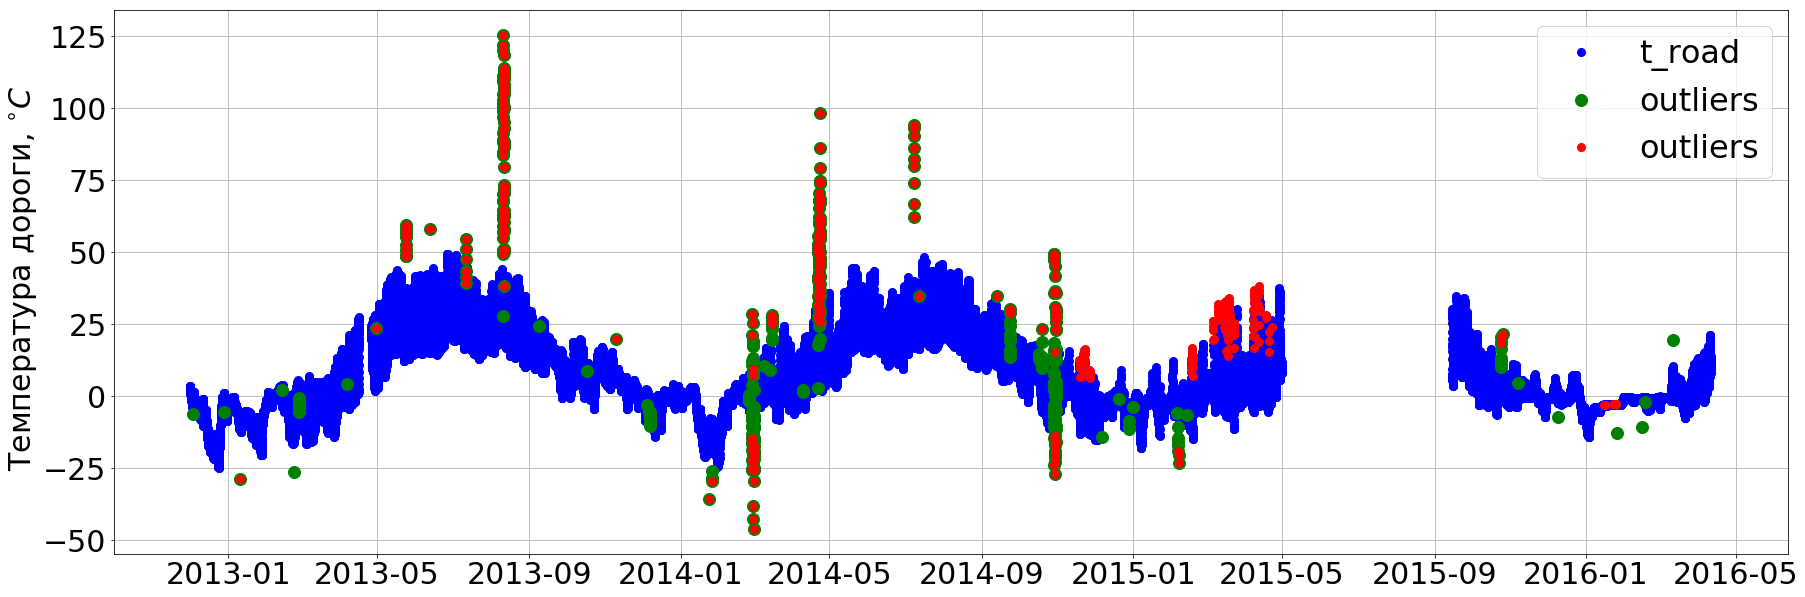

In [83]:
import matplotlib.pyplot as plt

#st_id = [114, 117, 119, 442, 504, 511, 1838, 1896]
#303, 307!!, 393!!, 503, 516
#test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
z = copy(df_test[df_test['station_id']==615].set_index('date_time_utc'))

start = pd.Timestamp(2012, 12, 1)
end = pd.Timestamp(2017, 2, 1)

to_plot = z[(z.index<=end) & (z.index>=start)]

plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    cond_true = (to_plot['label_true'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='t_road')
    else:
        
        plt.plot_date(to_plot[cond_true].index, to_plot[cond_true]['target_t_road'], 'g.',
                              linestyle='none', marker='o', label='outliers', markersize=12)
        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температура дороги, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()

In [20]:
z = df_test[['label_true', 'label_predict', 'decision_function']]
z.corr()

KeyError: "['label_predict' 'decision_function'] not in index"